In [7]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime

In [8]:
CL = 5

f = {f"{k}{i}": Value(dtype="string") for k in "ts" for i in range(CL)}
dataset = load_dataset("csv", 
                       data_files={split: f"../D0/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

In [9]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    encoding = tokenizer(examples[f"t{CL-1}"], max_length=128, truncation=True)

    return encoding

tokenized_dataset = dataset.map(preprocess_data, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

In [10]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=8)

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [12]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))
# loss_fn = nn.CrossEntropyLoss()

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
raise Exception

Exception: 

In [15]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=40,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

trainer = WeightedTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4840 [00:00<?, ?it/s]

{'loss': 2.0959, 'learning_rate': 5e-07, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 2.07370662689209, 'eval_WA': 0.13403263403263405, 'eval_UWA': 0.125, 'eval_miF1': 0.13403263403263405, 'eval_maF1': 0.02954779033915725, 'eval_wtF1': 0.031682945352010106, 'eval_runtime': 0.3831, 'eval_samples_per_second': 2239.772, 'eval_steps_per_second': 36.546, 'epoch': 1.0}
{'loss': 2.0866, 'learning_rate': 1e-06, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 2.068704605102539, 'eval_WA': 0.13403263403263405, 'eval_UWA': 0.125, 'eval_miF1': 0.13403263403263405, 'eval_maF1': 0.02954779033915725, 'eval_wtF1': 0.031682945352010106, 'eval_runtime': 0.3872, 'eval_samples_per_second': 2215.7, 'eval_steps_per_second': 36.154, 'epoch': 2.0}
{'loss': 2.078, 'learning_rate': 1.5e-06, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 2.0544872283935547, 'eval_WA': 0.29953379953379955, 'eval_UWA': 0.19434348980790161, 'eval_miF1': 0.29953379953379955, 'eval_maF1': 0.12347656380039283, 'eval_wtF1': 0.24825449914334366, 'eval_runtime': 0.3863, 'eval_samples_per_second': 2220.797, 'eval_steps_per_second': 36.237, 'epoch': 3.0}
{'loss': 2.0265, 'learning_rate': 2e-06, 'epoch': 4.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.9472085237503052, 'eval_WA': 0.1561771561771562, 'eval_UWA': 0.22690897904905472, 'eval_miF1': 0.1561771561771562, 'eval_maF1': 0.1109559254557904, 'eval_wtF1': 0.08697049212092593, 'eval_runtime': 0.3866, 'eval_samples_per_second': 2219.098, 'eval_steps_per_second': 36.209, 'epoch': 4.0}
{'loss': 1.9077, 'learning_rate': 1.9444444444444444e-06, 'epoch': 5.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.8184993267059326, 'eval_WA': 0.3414918414918415, 'eval_UWA': 0.32727588383828177, 'eval_miF1': 0.3414918414918415, 'eval_maF1': 0.2514932870107869, 'eval_wtF1': 0.3335273028541559, 'eval_runtime': 0.3864, 'eval_samples_per_second': 2220.692, 'eval_steps_per_second': 36.235, 'epoch': 5.0}
{'loss': 1.7587, 'learning_rate': 1.8888888888888888e-06, 'epoch': 6.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.7036000490188599, 'eval_WA': 0.44988344988344986, 'eval_UWA': 0.38338550871043886, 'eval_miF1': 0.44988344988344986, 'eval_maF1': 0.31330129066045675, 'eval_wtF1': 0.43159683101021046, 'eval_runtime': 0.3878, 'eval_samples_per_second': 2212.364, 'eval_steps_per_second': 36.099, 'epoch': 6.0}
{'loss': 1.6436, 'learning_rate': 1.833333333333333e-06, 'epoch': 7.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.6478608846664429, 'eval_WA': 0.4627039627039627, 'eval_UWA': 0.40394220323658614, 'eval_miF1': 0.4627039627039627, 'eval_maF1': 0.3266161030522421, 'eval_wtF1': 0.43618652798858454, 'eval_runtime': 0.3876, 'eval_samples_per_second': 2213.808, 'eval_steps_per_second': 36.123, 'epoch': 7.0}
{'loss': 1.5547, 'learning_rate': 1.7777777777777775e-06, 'epoch': 8.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.6044048070907593, 'eval_WA': 0.4755244755244755, 'eval_UWA': 0.40565986964311473, 'eval_miF1': 0.4755244755244755, 'eval_maF1': 0.33539206658949394, 'eval_wtF1': 0.44671561230109236, 'eval_runtime': 0.3865, 'eval_samples_per_second': 2219.894, 'eval_steps_per_second': 36.222, 'epoch': 8.0}
{'loss': 1.504, 'learning_rate': 1.7222222222222222e-06, 'epoch': 9.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.579200267791748, 'eval_WA': 0.47202797202797203, 'eval_UWA': 0.4103141940906044, 'eval_miF1': 0.47202797202797203, 'eval_maF1': 0.3376834221508514, 'eval_wtF1': 0.44419233347941134, 'eval_runtime': 0.3853, 'eval_samples_per_second': 2226.808, 'eval_steps_per_second': 36.335, 'epoch': 9.0}
{'loss': 1.4418, 'learning_rate': 1.6666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5724008083343506, 'eval_WA': 0.48484848484848486, 'eval_UWA': 0.42240696989717696, 'eval_miF1': 0.48484848484848486, 'eval_maF1': 0.3497236299547045, 'eval_wtF1': 0.4574859300823283, 'eval_runtime': 0.3895, 'eval_samples_per_second': 2203.058, 'eval_steps_per_second': 35.947, 'epoch': 10.0}
{'loss': 1.3971, 'learning_rate': 1.6111111111111111e-06, 'epoch': 11.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5525647401809692, 'eval_WA': 0.4801864801864802, 'eval_UWA': 0.43830625614579477, 'eval_miF1': 0.4801864801864802, 'eval_maF1': 0.35667147999382154, 'eval_wtF1': 0.45610460744966264, 'eval_runtime': 0.3847, 'eval_samples_per_second': 2230.256, 'eval_steps_per_second': 36.391, 'epoch': 11.0}
{'loss': 1.3683, 'learning_rate': 1.5555555555555556e-06, 'epoch': 12.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5392838716506958, 'eval_WA': 0.47785547785547783, 'eval_UWA': 0.4286862204866558, 'eval_miF1': 0.47785547785547783, 'eval_maF1': 0.35084759191070447, 'eval_wtF1': 0.45294897735840195, 'eval_runtime': 0.3878, 'eval_samples_per_second': 2212.429, 'eval_steps_per_second': 36.1, 'epoch': 12.0}
{'loss': 1.3378, 'learning_rate': 1.5e-06, 'epoch': 13.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5572797060012817, 'eval_WA': 0.4836829836829837, 'eval_UWA': 0.43938290547342146, 'eval_miF1': 0.4836829836829837, 'eval_maF1': 0.362055457642717, 'eval_wtF1': 0.4665680782514486, 'eval_runtime': 0.3895, 'eval_samples_per_second': 2202.873, 'eval_steps_per_second': 35.944, 'epoch': 13.0}
{'loss': 1.2925, 'learning_rate': 1.4444444444444443e-06, 'epoch': 14.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5224268436431885, 'eval_WA': 0.4662004662004662, 'eval_UWA': 0.43904299824822784, 'eval_miF1': 0.4662004662004662, 'eval_maF1': 0.35096831560958547, 'eval_wtF1': 0.4500234474894308, 'eval_runtime': 0.3825, 'eval_samples_per_second': 2243.385, 'eval_steps_per_second': 36.605, 'epoch': 14.0}
{'loss': 1.2657, 'learning_rate': 1.3888888888888887e-06, 'epoch': 15.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5275802612304688, 'eval_WA': 0.47435897435897434, 'eval_UWA': 0.4374349676616205, 'eval_miF1': 0.47435897435897434, 'eval_maF1': 0.35652466100133806, 'eval_wtF1': 0.45618740740528724, 'eval_runtime': 0.3829, 'eval_samples_per_second': 2240.943, 'eval_steps_per_second': 36.566, 'epoch': 15.0}
{'loss': 1.2295, 'learning_rate': 1.3333333333333332e-06, 'epoch': 16.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.519059181213379, 'eval_WA': 0.486013986013986, 'eval_UWA': 0.4537739827855302, 'eval_miF1': 0.486013986013986, 'eval_maF1': 0.37465873149962037, 'eval_wtF1': 0.4730297720551217, 'eval_runtime': 0.3847, 'eval_samples_per_second': 2230.284, 'eval_steps_per_second': 36.392, 'epoch': 16.0}
{'loss': 1.2037, 'learning_rate': 1.2777777777777777e-06, 'epoch': 17.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5305713415145874, 'eval_WA': 0.486013986013986, 'eval_UWA': 0.4445021722844305, 'eval_miF1': 0.486013986013986, 'eval_maF1': 0.3671331461197681, 'eval_wtF1': 0.4661567674417173, 'eval_runtime': 0.3878, 'eval_samples_per_second': 2212.263, 'eval_steps_per_second': 36.098, 'epoch': 17.0}
{'loss': 1.1912, 'learning_rate': 1.2222222222222223e-06, 'epoch': 18.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5391145944595337, 'eval_WA': 0.49184149184149184, 'eval_UWA': 0.4420409477479655, 'eval_miF1': 0.49184149184149184, 'eval_maF1': 0.3676256066670489, 'eval_wtF1': 0.47502719487297757, 'eval_runtime': 0.3888, 'eval_samples_per_second': 2207.065, 'eval_steps_per_second': 36.013, 'epoch': 18.0}
{'loss': 1.1549, 'learning_rate': 1.1666666666666668e-06, 'epoch': 19.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5296614170074463, 'eval_WA': 0.48484848484848486, 'eval_UWA': 0.4518233492414909, 'eval_miF1': 0.48484848484848486, 'eval_maF1': 0.3673285743352427, 'eval_wtF1': 0.4668565142411107, 'eval_runtime': 0.3874, 'eval_samples_per_second': 2215.037, 'eval_steps_per_second': 36.143, 'epoch': 19.0}
{'loss': 1.1237, 'learning_rate': 1.111111111111111e-06, 'epoch': 20.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5332444906234741, 'eval_WA': 0.49067599067599066, 'eval_UWA': 0.45847670347373526, 'eval_miF1': 0.49067599067599066, 'eval_maF1': 0.37499686032458596, 'eval_wtF1': 0.4736519215152426, 'eval_runtime': 0.3894, 'eval_samples_per_second': 2203.267, 'eval_steps_per_second': 35.951, 'epoch': 20.0}
{'loss': 1.0991, 'learning_rate': 1.0555555555555555e-06, 'epoch': 21.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5425399541854858, 'eval_WA': 0.49533799533799533, 'eval_UWA': 0.45251977698138823, 'eval_miF1': 0.49533799533799533, 'eval_maF1': 0.3760422435739442, 'eval_wtF1': 0.4844309743925322, 'eval_runtime': 0.3875, 'eval_samples_per_second': 2214.242, 'eval_steps_per_second': 36.13, 'epoch': 21.0}
{'loss': 1.0798, 'learning_rate': 1e-06, 'epoch': 22.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5456537008285522, 'eval_WA': 0.48484848484848486, 'eval_UWA': 0.4374957749484849, 'eval_miF1': 0.48484848484848486, 'eval_maF1': 0.36371213443356576, 'eval_wtF1': 0.4704102975005861, 'eval_runtime': 0.3877, 'eval_samples_per_second': 2213.173, 'eval_steps_per_second': 36.112, 'epoch': 22.0}
{'loss': 1.06, 'learning_rate': 9.444444444444444e-07, 'epoch': 23.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5409458875656128, 'eval_WA': 0.4988344988344988, 'eval_UWA': 0.46258249563009535, 'eval_miF1': 0.4988344988344988, 'eval_maF1': 0.3809345663222934, 'eval_wtF1': 0.48410645987116807, 'eval_runtime': 0.3866, 'eval_samples_per_second': 2219.384, 'eval_steps_per_second': 36.214, 'epoch': 23.0}
{'loss': 1.0513, 'learning_rate': 8.888888888888888e-07, 'epoch': 24.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5508238077163696, 'eval_WA': 0.49067599067599066, 'eval_UWA': 0.4578322519717386, 'eval_miF1': 0.49067599067599066, 'eval_maF1': 0.3734251308598978, 'eval_wtF1': 0.47549211544485004, 'eval_runtime': 0.388, 'eval_samples_per_second': 2211.442, 'eval_steps_per_second': 36.084, 'epoch': 24.0}
{'loss': 1.0295, 'learning_rate': 8.333333333333333e-07, 'epoch': 25.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.554385781288147, 'eval_WA': 0.4976689976689977, 'eval_UWA': 0.4623340050744006, 'eval_miF1': 0.4976689976689977, 'eval_maF1': 0.38345663647196215, 'eval_wtF1': 0.4802062546558439, 'eval_runtime': 0.3867, 'eval_samples_per_second': 2218.869, 'eval_steps_per_second': 36.205, 'epoch': 25.0}
{'loss': 1.0094, 'learning_rate': 7.777777777777778e-07, 'epoch': 26.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5588784217834473, 'eval_WA': 0.5023310023310024, 'eval_UWA': 0.46571553796254284, 'eval_miF1': 0.5023310023310024, 'eval_maF1': 0.388645801062924, 'eval_wtF1': 0.4831962295838684, 'eval_runtime': 0.3897, 'eval_samples_per_second': 2201.527, 'eval_steps_per_second': 35.922, 'epoch': 26.0}
{'loss': 0.9955, 'learning_rate': 7.222222222222221e-07, 'epoch': 27.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.563480019569397, 'eval_WA': 0.49417249417249415, 'eval_UWA': 0.45541180312602325, 'eval_miF1': 0.49417249417249415, 'eval_maF1': 0.37538987595264306, 'eval_wtF1': 0.4784132631754327, 'eval_runtime': 0.3855, 'eval_samples_per_second': 2225.491, 'eval_steps_per_second': 36.313, 'epoch': 27.0}
{'loss': 0.9995, 'learning_rate': 6.666666666666666e-07, 'epoch': 28.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5769463777542114, 'eval_WA': 0.5011655011655012, 'eval_UWA': 0.462699075071856, 'eval_miF1': 0.5011655011655012, 'eval_maF1': 0.3880232295535526, 'eval_wtF1': 0.4860238164420642, 'eval_runtime': 0.3908, 'eval_samples_per_second': 2195.68, 'eval_steps_per_second': 35.827, 'epoch': 28.0}
{'loss': 0.968, 'learning_rate': 6.111111111111112e-07, 'epoch': 29.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5747233629226685, 'eval_WA': 0.4965034965034965, 'eval_UWA': 0.4663666723341038, 'eval_miF1': 0.4965034965034965, 'eval_maF1': 0.38414964084700154, 'eval_wtF1': 0.48208401151721625, 'eval_runtime': 0.3813, 'eval_samples_per_second': 2250.221, 'eval_steps_per_second': 36.717, 'epoch': 29.0}
{'loss': 0.9569, 'learning_rate': 5.555555555555555e-07, 'epoch': 30.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5730863809585571, 'eval_WA': 0.49533799533799533, 'eval_UWA': 0.4587345430790338, 'eval_miF1': 0.49533799533799533, 'eval_maF1': 0.3786055921478594, 'eval_wtF1': 0.480198520394053, 'eval_runtime': 0.3804, 'eval_samples_per_second': 2255.415, 'eval_steps_per_second': 36.802, 'epoch': 30.0}
{'loss': 0.9498, 'learning_rate': 5e-07, 'epoch': 31.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5808870792388916, 'eval_WA': 0.4976689976689977, 'eval_UWA': 0.4567413785648558, 'eval_miF1': 0.4976689976689977, 'eval_maF1': 0.38264015012271174, 'eval_wtF1': 0.4823469716065431, 'eval_runtime': 0.3916, 'eval_samples_per_second': 2190.865, 'eval_steps_per_second': 35.748, 'epoch': 31.0}
{'loss': 0.958, 'learning_rate': 4.444444444444444e-07, 'epoch': 32.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.584403395652771, 'eval_WA': 0.48951048951048953, 'eval_UWA': 0.44894478850567204, 'eval_miF1': 0.48951048951048953, 'eval_maF1': 0.37336055764073317, 'eval_wtF1': 0.47574143212423725, 'eval_runtime': 0.3872, 'eval_samples_per_second': 2215.862, 'eval_steps_per_second': 36.156, 'epoch': 32.0}
{'loss': 0.9324, 'learning_rate': 3.888888888888889e-07, 'epoch': 33.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5934079885482788, 'eval_WA': 0.4976689976689977, 'eval_UWA': 0.4534161471558845, 'eval_miF1': 0.4976689976689977, 'eval_maF1': 0.38046083361602323, 'eval_wtF1': 0.48181344867810677, 'eval_runtime': 0.3864, 'eval_samples_per_second': 2220.409, 'eval_steps_per_second': 36.23, 'epoch': 33.0}
{'loss': 0.9453, 'learning_rate': 3.333333333333333e-07, 'epoch': 34.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.594933271408081, 'eval_WA': 0.49417249417249415, 'eval_UWA': 0.4477303825355333, 'eval_miF1': 0.49417249417249415, 'eval_maF1': 0.37537899251623763, 'eval_wtF1': 0.48029861283545067, 'eval_runtime': 0.3859, 'eval_samples_per_second': 2223.444, 'eval_steps_per_second': 36.28, 'epoch': 34.0}
{'loss': 0.933, 'learning_rate': 2.7777777777777776e-07, 'epoch': 35.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5977067947387695, 'eval_WA': 0.5023310023310024, 'eval_UWA': 0.4644351854515048, 'eval_miF1': 0.5023310023310024, 'eval_maF1': 0.3895821634662481, 'eval_wtF1': 0.48823214327734654, 'eval_runtime': 0.385, 'eval_samples_per_second': 2228.508, 'eval_steps_per_second': 36.363, 'epoch': 35.0}
{'loss': 0.9266, 'learning_rate': 2.222222222222222e-07, 'epoch': 36.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5959911346435547, 'eval_WA': 0.4965034965034965, 'eval_UWA': 0.4599030378963932, 'eval_miF1': 0.4965034965034965, 'eval_maF1': 0.3825423634479406, 'eval_wtF1': 0.48261068424070086, 'eval_runtime': 0.3854, 'eval_samples_per_second': 2226.472, 'eval_steps_per_second': 36.329, 'epoch': 36.0}
{'loss': 0.9272, 'learning_rate': 1.6666666666666665e-07, 'epoch': 37.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5905818939208984, 'eval_WA': 0.49533799533799533, 'eval_UWA': 0.4505496760137942, 'eval_miF1': 0.49533799533799533, 'eval_maF1': 0.37726340519699675, 'eval_wtF1': 0.4829221503841148, 'eval_runtime': 0.3839, 'eval_samples_per_second': 2235.209, 'eval_steps_per_second': 36.472, 'epoch': 37.0}
{'loss': 0.9238, 'learning_rate': 1.111111111111111e-07, 'epoch': 38.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5953856706619263, 'eval_WA': 0.48951048951048953, 'eval_UWA': 0.44554198498042175, 'eval_miF1': 0.48951048951048953, 'eval_maF1': 0.37247195065569727, 'eval_wtF1': 0.4760727620813067, 'eval_runtime': 0.3853, 'eval_samples_per_second': 2226.601, 'eval_steps_per_second': 36.331, 'epoch': 38.0}
{'loss': 0.9151, 'learning_rate': 5.555555555555555e-08, 'epoch': 39.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.596505880355835, 'eval_WA': 0.49184149184149184, 'eval_UWA': 0.44667382046624377, 'eval_miF1': 0.49184149184149184, 'eval_maF1': 0.374699647469631, 'eval_wtF1': 0.4783685940287064, 'eval_runtime': 0.3903, 'eval_samples_per_second': 2198.028, 'eval_steps_per_second': 35.865, 'epoch': 39.0}
{'loss': 0.9138, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.5983422994613647, 'eval_WA': 0.49533799533799533, 'eval_UWA': 0.44934740656134464, 'eval_miF1': 0.49533799533799533, 'eval_maF1': 0.37800280789142016, 'eval_wtF1': 0.48096892292925203, 'eval_runtime': 0.3871, 'eval_samples_per_second': 2216.71, 'eval_steps_per_second': 36.17, 'epoch': 40.0}
{'train_runtime': 513.964, 'train_samples_per_second': 597.785, 'train_steps_per_second': 9.417, 'train_loss': 1.255892999507179, 'epoch': 40.0}


TrainOutput(global_step=4840, training_loss=1.255892999507179, metrics={'train_runtime': 513.964, 'train_samples_per_second': 597.785, 'train_steps_per_second': 9.417, 'train_loss': 1.255892999507179, 'epoch': 40.0})

In [ ]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 1.3856546878814697,
 'eval_WA': 0.516642547033285,
 'eval_UWA': 0.5217326527942552,
 'eval_miF1': 0.516642547033285,
 'eval_maF1': 0.38615641129546785,
 'eval_wtF1': 0.511293767854692,
 'eval_runtime': 1.2518,
 'eval_samples_per_second': 2208.101,
 'eval_steps_per_second': 35.151,
 'epoch': 20.0}

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [ ]:
preds

NameError: name 'preds' is not defined

In [ ]:
for i in range(8):
    right = preds["labels"] == i and preds["pred"] == i
    print(sum(right)/len(preds))

NameError: name 'preds' is not defined

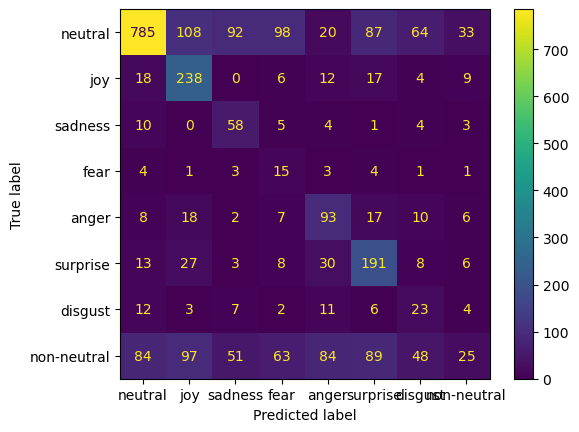

In [ ]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)